# Data acquisition

In [19]:
import requests

url = "http://kthdatabase.theworkpc.com:8086/query?db=kth_db&u=kth_group&p=hypergryd22&--data-urlencode&q=SELECT%20*%20FROM%20%22flow_08007%22%20where%20time%20%3E%20%272024-01-01T23:59:59Z%27%20and%20time%20%3C%20%272024-12-31T00:00:00Z%27"
headers = {
    "User-Agent": "Mozilla/5.0"
}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    data = response.text  
    with open("flow_08007.json", "w", encoding="utf-8") as f:
        f.write(data)
    print("Data saved to data.json")
else:
    print("Error, status code:", response.status_code)



Data saved to data.json


##### Total Length: ~212000, 2024-01: 21209

21209


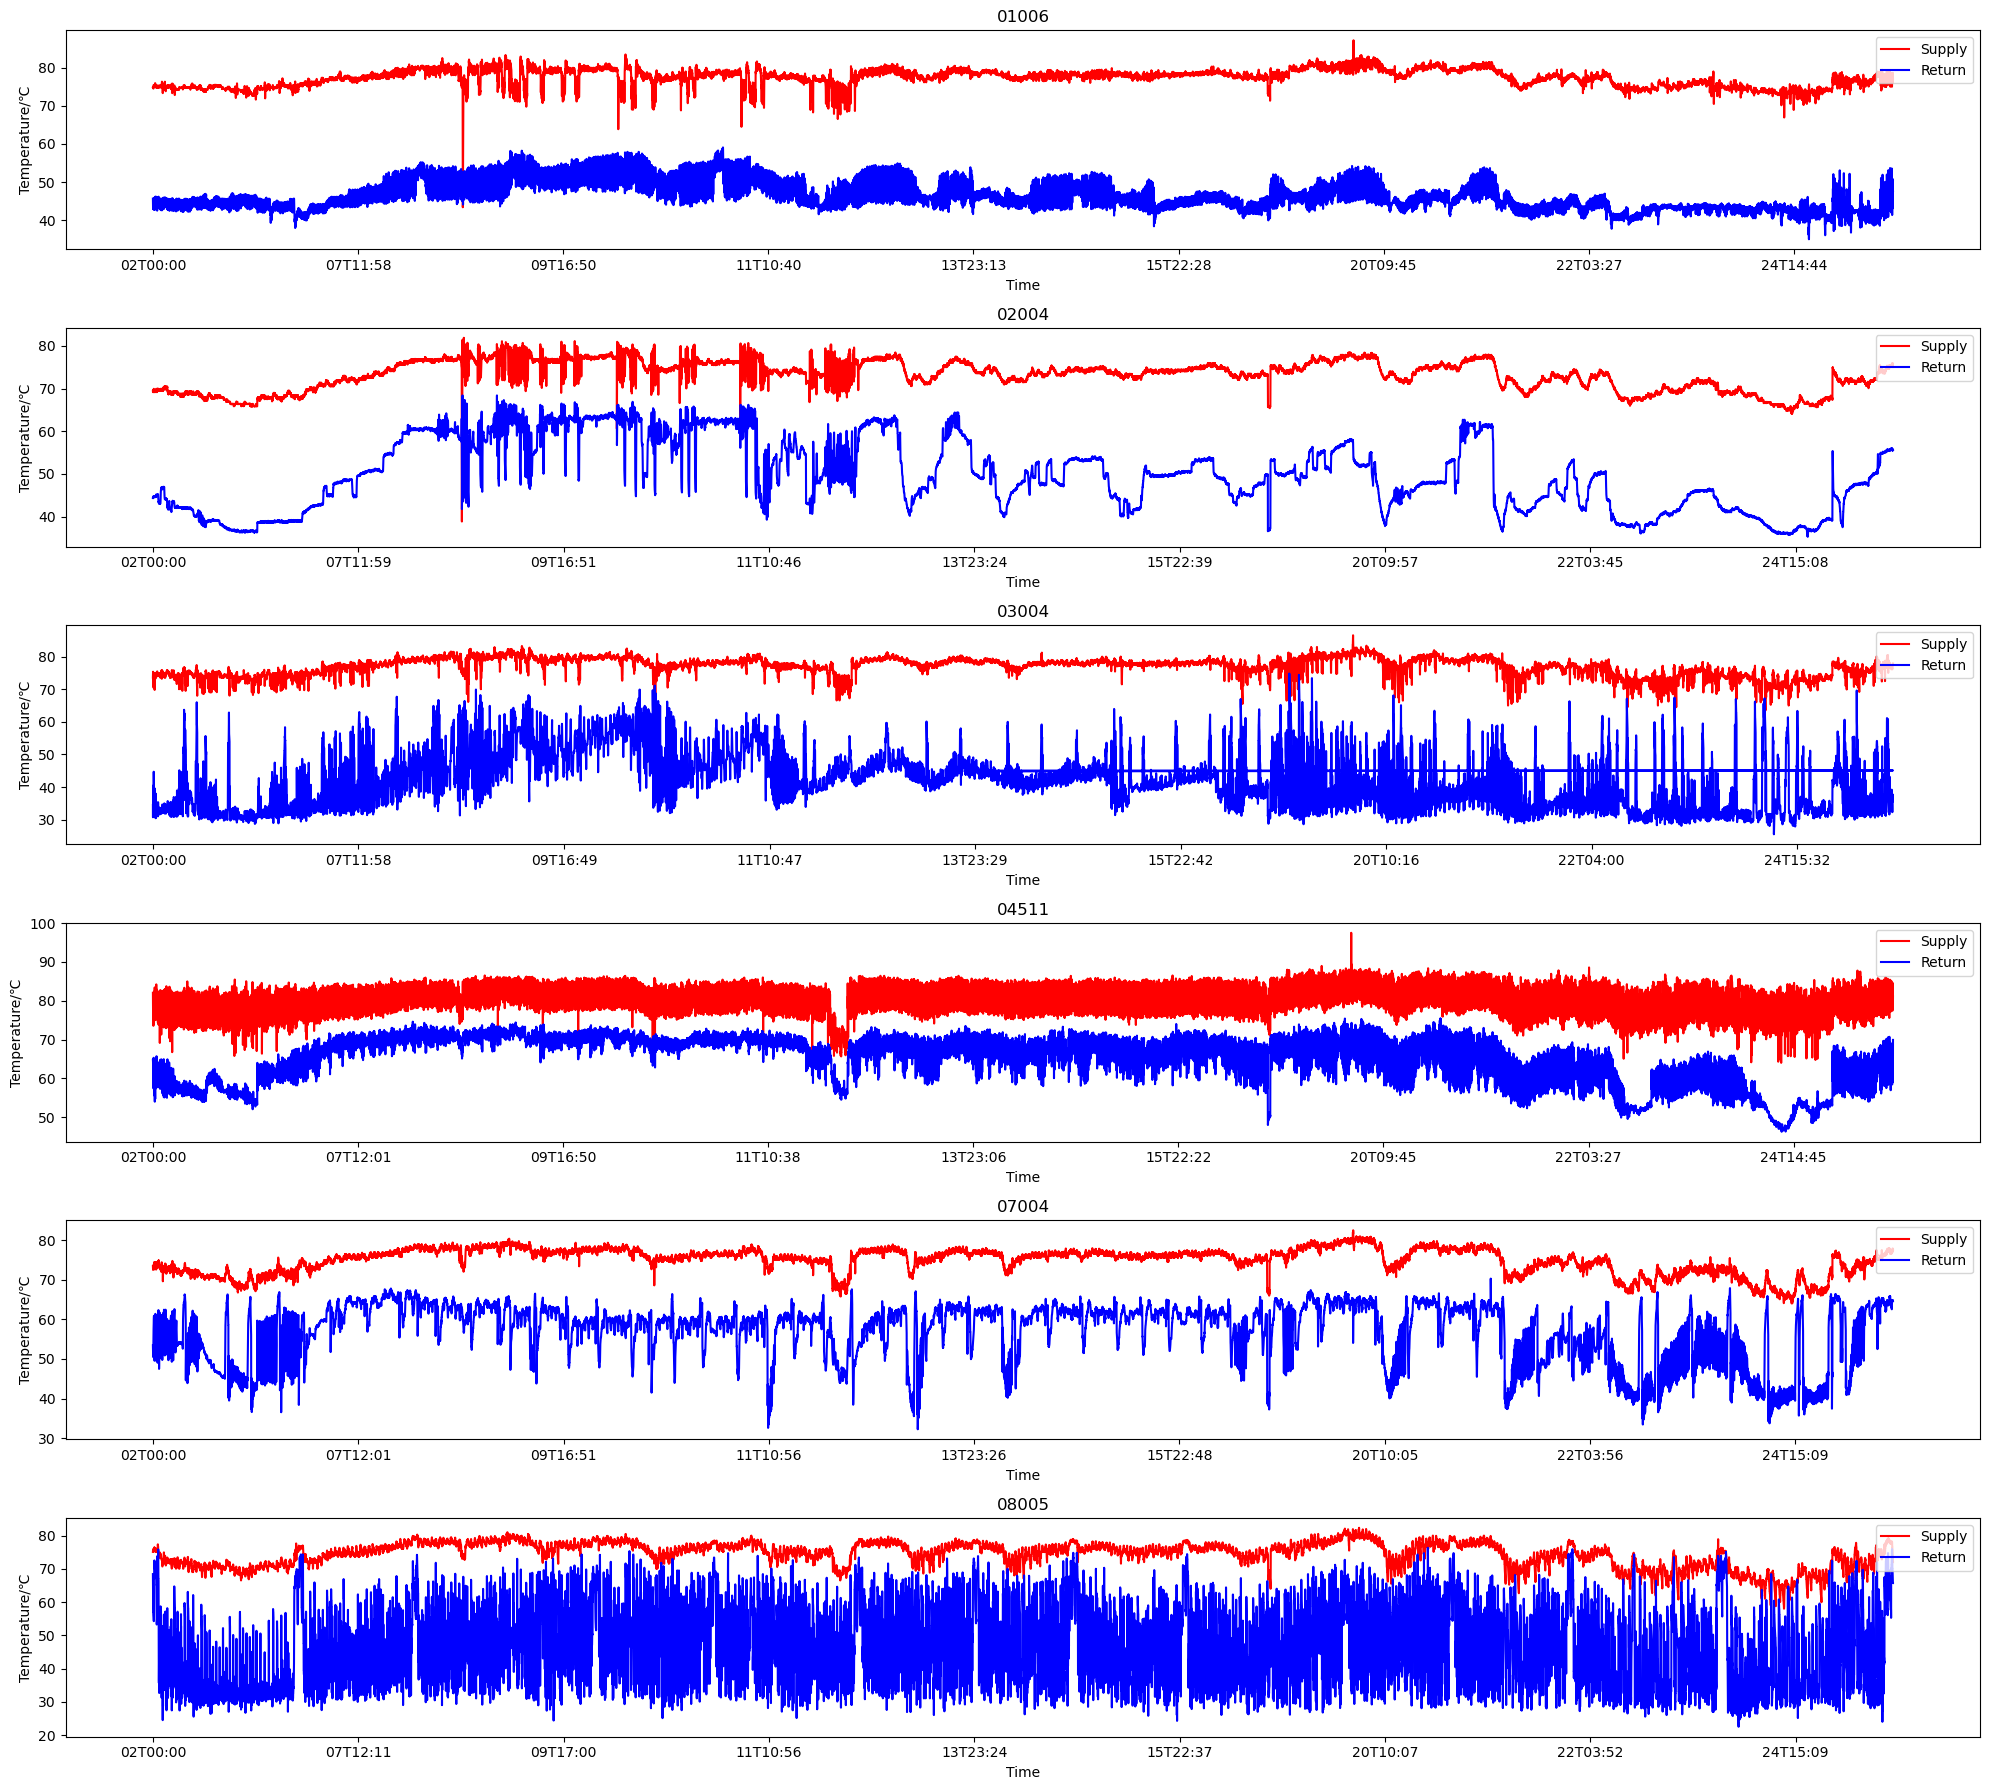

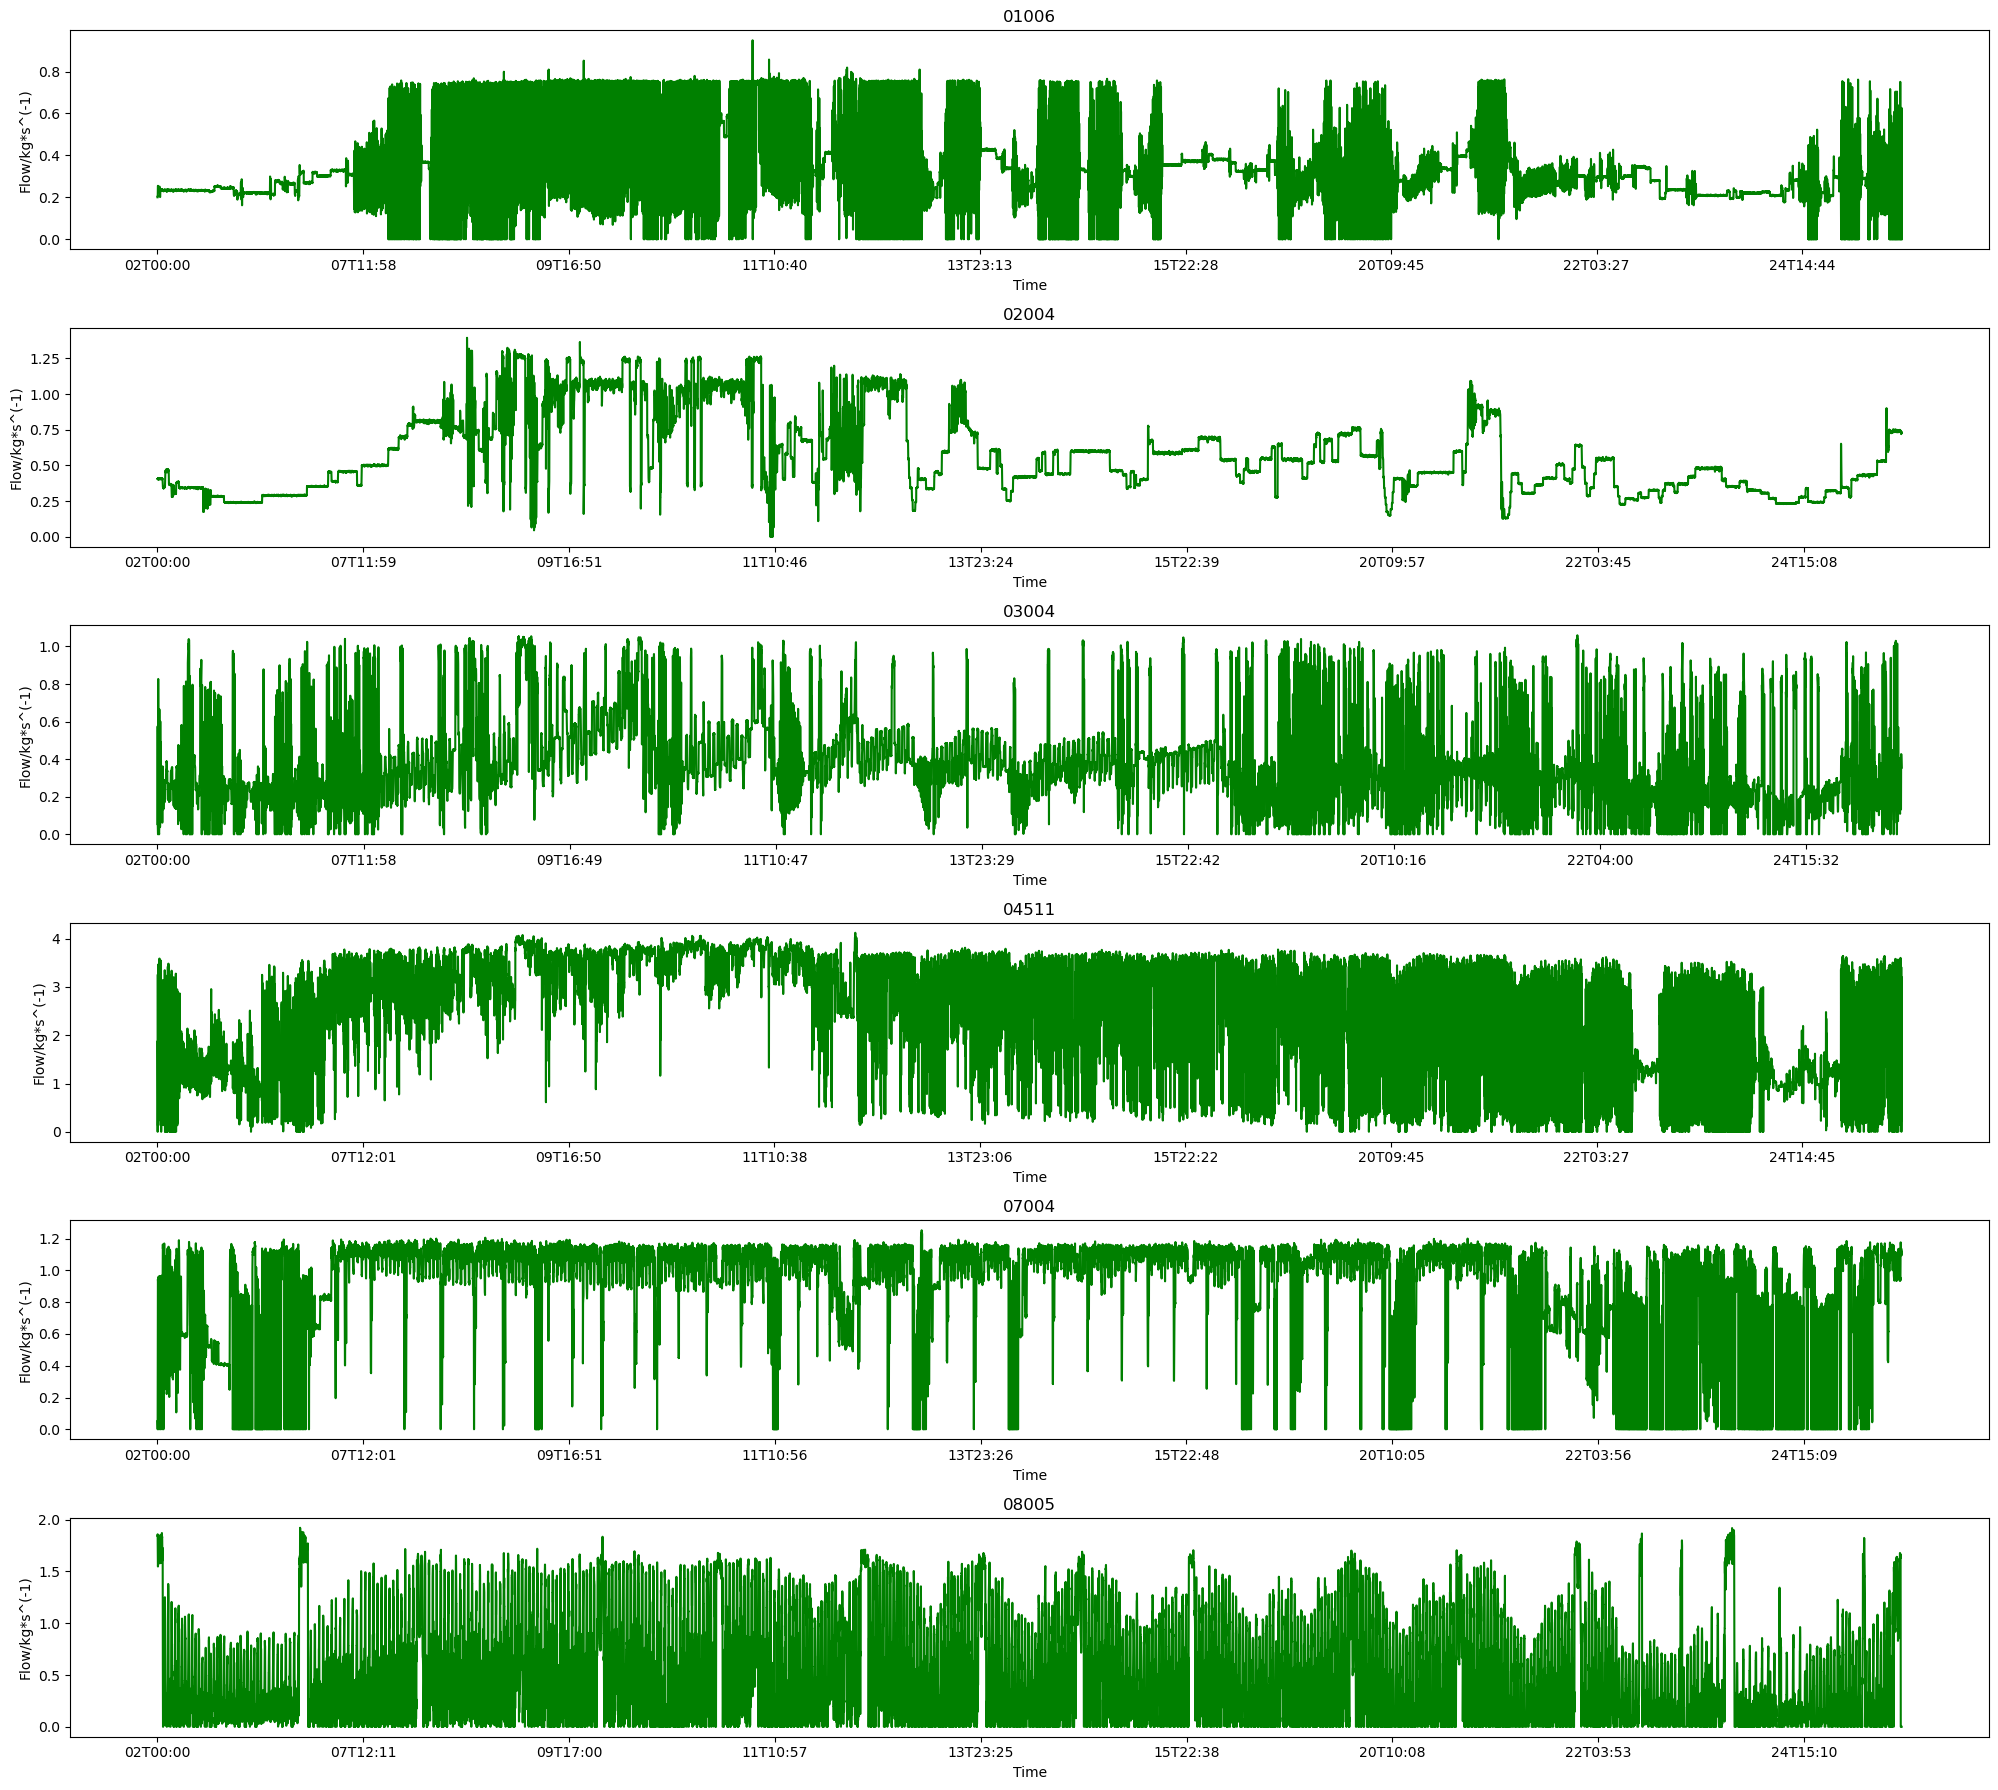

In [ ]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

path_to_flow = Path('./dataset/Flow') 
path_to_Return = Path('./dataset/ReturnT')
path_to_Supply = Path('./dataset/SupplyT')

start = "2024-01-02T00:00:00Z"
end = "2024-01-30T00:39:00Z"  #Make sure the time is valid
record = False

flow_time = []
flow_name = []
flow_value = []  # Two dimensions list
for file in path_to_flow.rglob('*.json'):
    with open(file, 'r', encoding='utf-8') as load_f:
        load_dict = json.load(load_f)
        flow_name.append(load_dict["results"][0]["series"][0]["name"])
        tmp1 = []
        tmp2 = []
        for i in load_dict["results"][0]["series"][0]["values"]:
            if i[0] == start:
                record = True
            elif i[0] == end:
                break
            if record:
                tmp1.append(i[0][8:16])
                tmp2.append(i[1])
        record = False
        flow_time.append(tmp1)
        flow_value.append(tmp2)
        print(len(tmp1))

tempR_time = []
tempR_name = []
tempR_value = []  # Two dimensions list
for file in path_to_Return.rglob('*.json'):
    with open(file, 'r', encoding='utf-8') as load_f:
        load_dict = json.load(load_f)
        tempR_name.append(load_dict["results"][0]["series"][0]["name"])
        tmp1 = []
        tmp2 = []
        for i in load_dict["results"][0]["series"][0]["values"]:
            if i[0] == start:
                record = True
            elif i[0] == end:
                break
            if record:
                tmp1.append(i[0][8:16])
                tmp2.append(i[1])
        record = False
        tempR_time.append(tmp1)
        tempR_value.append(tmp2)

tempS_time = []
tempS_name = []
tempS_value = []  # Two dimensions list
for file in path_to_Supply.rglob('*.json'):
    with open(file, 'r', encoding='utf-8') as load_f:
        load_dict = json.load(load_f)
        tempS_name.append(load_dict["results"][0]["series"][0]["name"])
        tmp1 = []
        tmp2 = []
        for i in load_dict["results"][0]["series"][0]["values"]:
            if i[0] == start:
                record = True
            elif i[0] == end:
                break
            if record:
                tmp1.append(i[0][8:16])
                tmp2.append(i[1])
        record = False
        tempS_time.append(tmp1)
        tempS_value.append(tmp2)

load = []
name = ["01006", "02004", "03004", "04511", "07004", "08005"]
for i in range(6):
    tmp = []
    for j in range(len(flow_value[i])):
        tmp.append(4.18 * flow_value[i][j] * (tempS_value[i][j] - tempR_value[i][j]))
    load.append(tmp)

plt.figure(figsize=(20, 18))
for i in range(6):
    plt.subplot(6, 1, (i+1))
    plt.title(name[i])
    plt.xlabel("Time")
    plt.ylabel("Temperature/℃")
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2500))
    plt.plot(tempS_time[i], tempS_value[i], color='red', label="Supply")
    plt.plot(tempR_time[i], tempR_value[i], color='blue', label="Return")
    plt.legend(loc="upper right")
    # ax = plt.twinx()
    # ax.set_ylabel("Flow/kg*s^(-1)")
    # ax.plot(flow_time[i], flow_value[i], color = 'green')
    plt.tight_layout()

plt.figure(figsize=(20, 18))
for i in range(6):
    plt.subplot(6, 1, (i+1))
    plt.title(name[i])
    plt.xlabel("Time")
    plt.ylabel("Flow/kg*s^(-1)")
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2500))
    plt.plot(flow_time[i], flow_value[i], color = 'green')
    plt.tight_layout()



# Prediction and detection

#### For supply temperature: T range and T change (short period like 1 day)
* T range use z-score: μ = 70, σ = 2, health rate = health samples / all
* Fluctuation detector: First run the previous cell!!

[8855.40845489502, 7470.593116760254, 9840.375381469727, 94403.16430664062, 5696.5130615234375, 6153.420249938965]
7894.04
5.416959932688035
11.37306303231514
7.415984403670019
13.93533172643418
10.078851807655372
13.340748752971182
[0.27417605733415057, 0.7590617330564471, 0.3120865620865621, 0.14180652460871204, 0.5286705365991788, 0.5647064376061922]


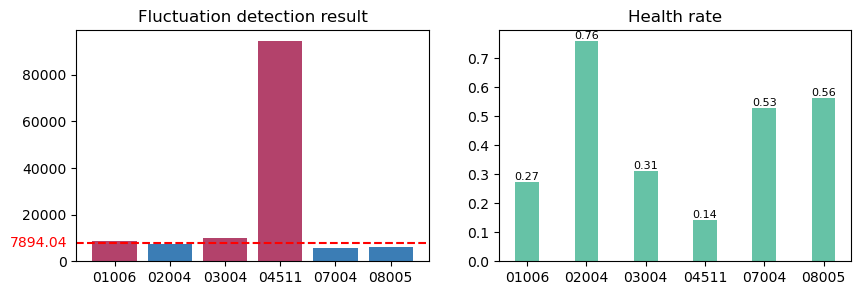

In [2]:
from sklearn.cluster import KMeans
import warnings
import copy

warnings.filterwarnings("ignore")

colorlist = [(0.4, 0.76, 0.65),
             (0.99, 0.55, 0.3),
             (0.55, 0.6, 0.80),
             (0.23, 0.49, 0.71),
             (0.94, 0.65, 0.12),
             (0.70, 0.26, 0.42),
             (0.86, 0.82, 0.11)]

def Fluctuation(list):
    changesum = 0
    for i in range(len(list) - 1):
        changesum += np.abs(list[i + 1] - list[i])
    return changesum

supply_changesum = []
for i in range(6):
    supply_changesum.append(Fluctuation(tempS_value[i]))

d = pd.DataFrame({'C':supply_changesum})
df = d.drop(index=3)
km = KMeans(n_clusters=2).fit(df)
x = np.arange(0, 15000, 0.01)
df = pd.DataFrame({'C': x})
pre = km.predict(df)
for i in range(1, len(pre)):
    if pre[i] != pre[i - 1]:
        boundary = i / 100
        break

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.title("Fluctuation detection result")
name = ["01006", "02004", "03004", "04511", "07004", "08005"]
c = [colorlist[3] if i < boundary else colorlist[5] for i in supply_changesum]
plt.bar(name, supply_changesum, color = c)
plt.axhline(y=boundary, color='red', linestyle='--')
plt.text(x=-0.85, y=boundary, s=f"{boundary}", va='center', ha='right', fontsize=10, color='r')
# for i in range(len(name)):
#     plt.text(name[i], supply_changesum[i], s=f"{format(supply_changesum[i], '.2f')}", va='bottom', ha='center', fontsize=8)

print(supply_changesum)
print(boundary)

health_rate = []
health_series = copy.deepcopy(tempS_value)
# del health_series[2: 4]
for i in health_series:
    cnt = 0
    var = np.var(i)
    print(var)
    upper = 76 #70 + 3 * var
    lower = 64 #70 - 3 * var
    for j in i:
        if (j > lower) & (j < upper):
            cnt+=1
    health_rate.append(cnt / len(i))
print(health_rate)

plt.subplot(122)
plt.title("Health rate")
plt.bar(name, health_rate, color = colorlist[0], width=0.4)
for i in range(len(name)):
    plt.text(name[i], health_rate[i], s=f"{format(health_rate[i], '.2f')}", va='bottom', ha='center', fontsize=8)


#### Auto-encoder: flow
* Samples: total 21209 data, make each sample 7 days length, 4800 data points
* 1 model/building, anomaly means significant anomaly

In [42]:
import tensorflow as tf
from sklearn import preprocessing
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

def Create_dataset(data, data_index, num_dimensions):
    max_start_index = len(data) - num_dimensions
    start_indices = np.linspace(0, max_start_index, max_start_index + 1, dtype=int)
    df = pd.DataFrame(np.array([data[i:i + num_dimensions] for i in start_indices]), 
                      index=np.array([data_index[i] for i in start_indices]))
    return df

def AutoEncoder_build(model, X_train, act_func):
    tf.random.set_seed(10)
    model = tf.keras.Sequential() 
    # First hidden layer, connected to input vector X.
    model.add(tf.keras.layers.Dense(180,activation=act_func, # activation function
                    kernel_initializer='glorot_uniform', # Weight initialization
                    kernel_regularizer=tf.keras.regularizers.l2(0.01), # Regularization to prevent overfitting, 0.01, 0.01, 0.05 for 1, 7, 8
                    input_shape=(X_train.shape[1],)
                   )
             )
    # model.add(tf.keras.layers.Dense(135,activation=act_func,
    #                 kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dense(16,activation=act_func,
                    kernel_initializer='glorot_uniform'))
    # model.add(tf.keras.layers.Dense(135,activation=act_func,
    #                 kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dense(180,activation=act_func,
                    kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dense(X_train.shape[1],
                    kernel_initializer='glorot_uniform'))
    model.compile(loss='mse',optimizer='adam') 
    print(model.summary())
    return model

def AutoEncoder_main(model, X_train, Epochs,BATCH_SIZE,validation_split):
    # Train model for 100 epochs, batch size of 10:
	# noise
    factor = 0
    X_train_noise = X_train + factor * np.random.normal(0, 1, X_train.shape)
    X_train_noise = np.clip(X_train_noise,0.,1.)
    
    history = model.fit(np.array(X_train_noise),np.array(X_train),
                        batch_size=BATCH_SIZE,
                        epochs=Epochs,
                        shuffle=True,
                        validation_split=validation_split, # Training set ratio
    #                       validation_data=(X_train,X_train), # Validation set
                        verbose = 1)

    return history

def plot_AE_history(history):
    plt.plot(history.history['loss'],
             'b',
             label='Training loss')
    plt.plot(history.history['val_loss'],
             'r',
             label='Validation loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss, [mse]')
    plt.ylim([0,.1])
    plt.show()

In [30]:
health_rate = []
flow_anomaly = []

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 180)            │       864,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │         2,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 180)            │         3,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 4800)           │       868,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,936 (6.63 MB)

 Trainable params: 1,738,936 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 5.0333 - val_loss: 0.0731
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0765 - val_loss: 0.0666
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0765 - val_loss: 0.0680
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0758 - val_loss: 0.0677
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0761 - val_loss: 0.0640
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0750 - val_loss: 0.0646
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0750 - val_loss: 0.0692
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0764 - val_loss: 0.0638
Epoch 9/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0772 - val_loss: 0.0669
Epoch 10/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0751 - val_loss: 0.0686
Epoch 11/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0761 - val_loss: 0.0656
Epoch 12/100
103/103 ━━━

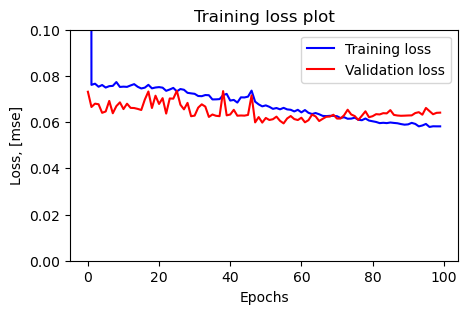

513/513 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1.0


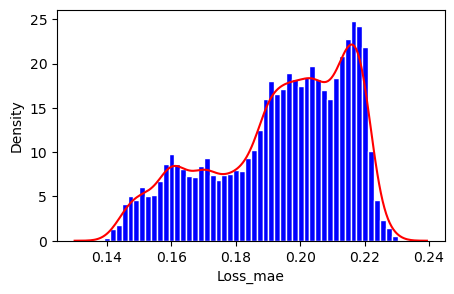

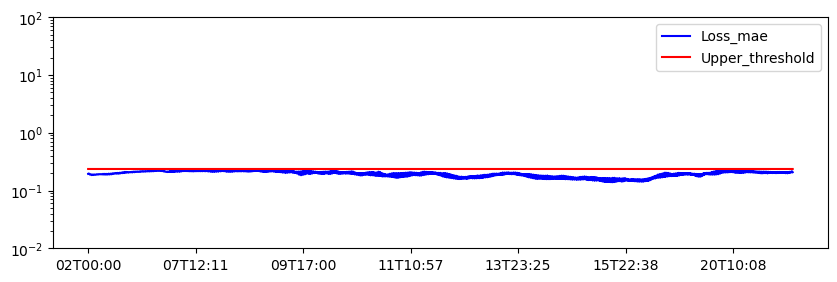

In [31]:
df = Create_dataset(flow_value[5], flow_time[5], 4800)

flow_scaler = preprocessing.MinMaxScaler()

X = pd.DataFrame(flow_scaler.fit_transform(df), 
                            columns=df.columns,
                            index=df.index)
# Build AutoEncoding model
flow_model = tf.keras.Sequential()
flow_model = AutoEncoder_build(model=flow_model,X_train=X, act_func='relu')
history = AutoEncoder_main(flow_model, X, 100, 128, 0.2)   

plt.figure(figsize=(5, 3))
plt.title("Training loss plot")
plot_AE_history(history)

# For training set
X_pred = flow_model.predict(np.array(X))
X_pred = pd.DataFrame(X_pred,
                    columns=X.columns)
X_pred.index = X.index

scored = pd.DataFrame(index=X.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X), axis = 1)

plt.figure(figsize=(5, 3))
hist = plt.hist(scored['Loss_mae'], bins=50, edgecolor='white', density=True, color='blue')
# plt.title("MAE density plot for training set" + str(i))
sns.kdeplot(scored['Loss_mae'], color='red')

#For testing set
X_pred = flow_model.predict(np.array(X))
X_pred = pd.DataFrame(X_pred, columns=X.columns)
X_pred.index = X.index

scored = pd.DataFrame(index=X.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X), axis = 1)
miu = np.mean(scored['Loss_mae'])
sigma = np.std(scored['Loss_mae'])
scored['Upper_threshold'] = miu + 2 * sigma
# scored['Lower_threshold'] = miu - 35 * sigma
scored['Anomaly'] = scored['Loss_mae'] > scored['Upper_threshold'] 

# X_pred_train = flow_model.predict(np.array(X_train))
# X_pred_train = pd.DataFrame(X_pred_train,
#                       columns=X_train.columns)
# X_pred_train.index = X_train.index

# scored_train = pd.DataFrame(index=X_train.index)
# scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
# scored_train['Threshold'] = flow_threshold
# scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
# scored = pd.concat([scored_train, scored])

scored.plot(logy=True,  figsize = (10,3), ylim = [1e-2,1e2], color = ['blue','red'])

df_anomalies = df.loc[scored[scored['Anomaly']].index]

cnt = 0
for j in scored['Anomaly']:
    if j == False:
        cnt += 1
health_rate.append(cnt/len(scored['Anomaly']))
flow_anomaly.append(df_anomalies)
print(cnt/len(scored['Anomaly']))



In [33]:

miu = np.mean(scored['Loss_mae'])
sigma = np.std(scored['Loss_mae'])
print(miu, sigma)
scored['Upper_threshold'] = miu + 2 * sigma
scored['Lower_threshold'] = miu - 2 * sigma
scored['Anomaly'] = (scored['Loss_mae'] > scored['Upper_threshold']) | (scored['Loss_mae'] < scored['Lower_threshold'])

cnt = 0
for j in scored['Anomaly']:
    if j == False:
        cnt += 1
print(cnt/len(scored['Anomaly']))
print(health_rate)
print(flow_anomaly)


0.1937061413360125 0.021189629744111517
0.9610690749328777
[1.0]
[Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]
Index: []

[0 rows x 4800 columns]]


#### Use the Auto-encoder to detect anomaly 

In [34]:
df_pred = pd.DataFrame(flow_scaler.inverse_transform(X_pred), index=X_pred.index, columns=X_pred.columns)

df_anomalies_pred = df_pred.loc[scored[scored['Anomaly']].index] # for significant anomaly


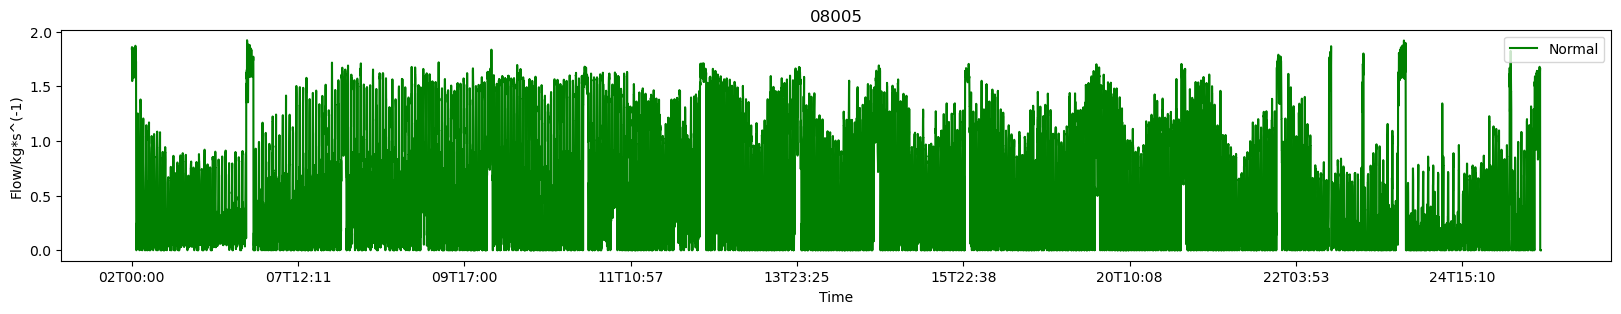

In [36]:
j = 5   #The building index

idx = []
for i in flow_anomaly[0].index:
    if i in flow_time[j]:
        idx.append(range(flow_time[j].index(i), flow_time[j].index(i) + 4800))
idx = np.unique(idx)

plt.figure(figsize=(20, 3))
plt.title(name[j])
plt.xlabel("Time")
plt.ylabel("Flow/kg*s^(-1)")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2500))
plt.plot(flow_time[j], flow_value[j], color = 'green', label = 'Normal')
if len(idx):
    start = [idx[0]]
    end = []
    for k in range(1, len(idx)):
        if idx[k] != idx[k-1] + 1:
            start.append(idx[k])
            end.append(idx[k-1])
    end.append(idx[-1])
    flag = True
    for x, y in zip(start, end):
        plt.plot(np.array(flow_time[j])[x: y], np.array(flow_value[j])[x: y], color = 'orange', label = 'Anomaly' if flag else None)
        flag = False
plt.legend(loc = 'upper right')

# plt.figure(figsize=(20, 3))
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(200))
# flag = True
# for x, y in zip(start, end):
#     plt.plot(np.array(flow_time[j])[x: x+1000], np.array(flow_value[j])[x: x+1000], color = 'orange', label = 'Anomaly' if flag else None)
#     temp = df_anomalies_pred[flow_time[j][x]: flow_time[j][x]]
#     plt.plot(np.array(flow_time[j])[x: x+1000], np.array(temp[0: 1000]), color = 'green', label = 'Normal') 
#     flag = False  
# plt.legend(loc = 'upper right')         

# plt.figure(figsize=(20, 3))
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(200))
# flag = True
# for x, y in zip(start, end):
#     plt.plot(np.array(flow_time[j])[y-1000: y], np.array(flow_value[j])[y-1000: y], color = 'orange', label = 'Anomaly' if flag else None)
#     temp = df_anomalies_pred[flow_time[j][y-4800]: flow_time[j][y-4800]]
#     plt.plot(np.array(flow_time[j])[y-1000: y], np.array(temp[-1000: ]), color = 'green', label = 'Normal')   
#     flag = False  
# plt.legend(loc = 'upper right')  

# plt.figure(figsize=(20, 3))
# flag = True
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(200))
# for x, y in zip(start, end):
#     plt.plot(np.array(flow_time[j])[x+2000: x+3000], np.array(flow_value[j])[x+2000: x+3000], color = 'orange', label = 'Anomaly' if flag else None)
#     temp = df_anomalies_pred[flow_time[j][x]: flow_time[j][x]]        
#     plt.plot(np.array(flow_time[j])[x+2000: x+3000], np.array(temp[2000: 3000]), color = 'green', label = 'Normal')   
#     flag = False 
# plt.legend(loc = 'upper right')    

# plt.tight_layout()


[[0.19164494]
 [0.21318844]
 [0.16142393]]
The size of SOM: 26 * 26


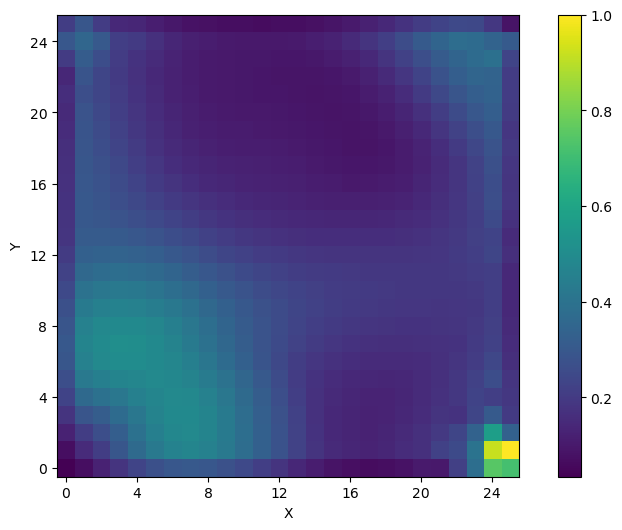

In [42]:
from minisom import MiniSom
from matplotlib.gridspec import GridSpec
import math
from sklearn.cluster import KMeans
import warnings
import copy

warnings.filterwarnings("ignore")

df = Create_dataset(flow_value[5], flow_time[5], 4800)  #The building index
X = pd.DataFrame(scored['Loss_mae'], index=scored.index)

std = []
mean = []
for i in np.array(df):
    mean.append(np.mean(i))
    std.append(np.std(i))

km = KMeans(n_clusters=3).fit(X)
centroid = km.cluster_centers_
print(centroid)
repre = []
for i in centroid.flatten():
    idx = np.abs(np.array(scored['Loss_mae']) - i).argmin()
    repre.append(idx)
    
# elbow = []
# for i in range(1, 20):  
#    kmeans = KMeans(n_clusters=i)
#    kmeans.fit(X)
#    elbow.append(kmeans.inertia_)

# k_num = [i for i in range(1, 20)]
# plt.plot(k_num, elbow, color='blue')
# plt.rcParams.update({'figure.figsize': (16, 10), 'figure.dpi': 100})
# plt.title('Elbow Method')
# plt.show()

N = X.shape[0]   # length
M = X.shape[1]  # dimension
size = math.ceil(np.sqrt(5 * np.sqrt(N)))
print("The size of SOM: {} * {}".format(size, size))
max_iter = 200
X = np.array(X)
som = MiniSom(size, size, M, sigma=size/2, learning_rate=0.5, neighborhood_function='gaussian')  # sigma determines the range of updating neurons
# som.pca_weights_init(X)
som.train_batch(X, max_iter)

plt.figure(figsize=(10, 6))
heatmap = som.distance_map()  
plt.xlabel("X")
plt.ylabel("Y") 
# plt.title("SOM clustering visualization")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(4))
plt.imshow(heatmap) 
plt.gca().invert_yaxis()
plt.colorbar()






[10102, 14548, 13055]


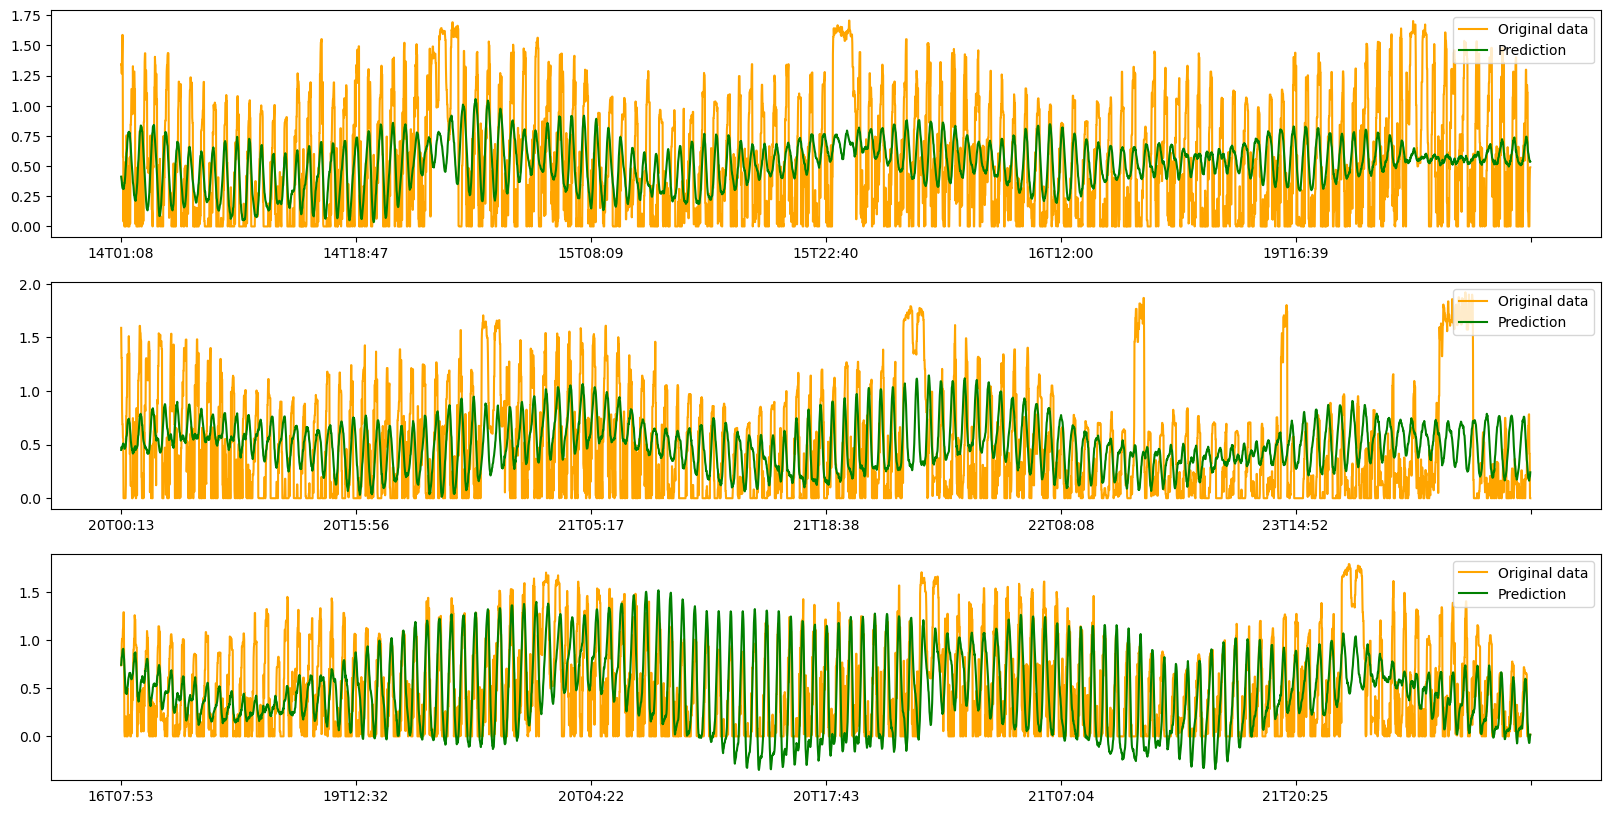

In [44]:
print(repre)
plt.figure(figsize=(20, 10))
for i in range(len(repre)):
    plt.subplot(len(repre), 1, i+1)
    idx = repre[i]
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(800))
    plt.plot(flow_time[5][idx: idx+4800], flow_value[5][idx: idx+4800], color='orange', label='Original data')  # building index!
    temp = df_pred[flow_time[5][idx]: flow_time[5][idx]]
    temp = np.array(temp).flatten()
    plt.plot(flow_time[5][idx: idx+4800], temp[0: 4800], color='green', label='Prediction')
    plt.legend(loc='upper right')

    

#### Auto-encoder for supply temperature
* Training set: 02

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 180)            │       864,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │         2,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 180)            │         3,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 4800)           │       868,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,936 (6.63 MB)

 Trainable params: 1,738,936 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 1.1496 - val_loss: 0.0392
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0165 - val_loss: 0.0335
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0139 - val_loss: 0.0271
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0152 - val_loss: 0.0320
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0157 - val_loss: 0.0313
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0141 - val_loss: 0.0272
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0151 - val_loss: 0.0332
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0146 - val_loss: 0.0337
Epoch 9/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0134 - val_loss: 0.0365
Epoch 10/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0144 - val_loss: 0.0357
Epoch 11/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0169 - val_loss: 0.0289
Epoch 12/100
103/103 ━━━━

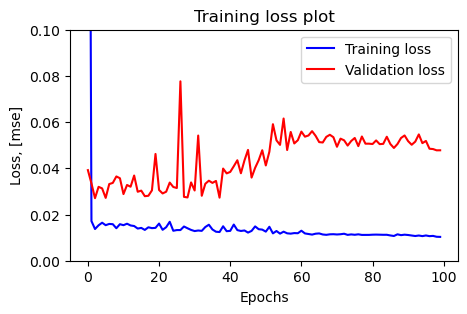

513/513 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
0.9150649826102873


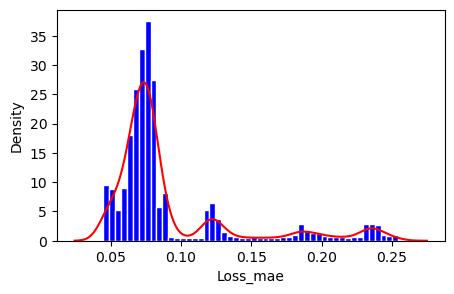

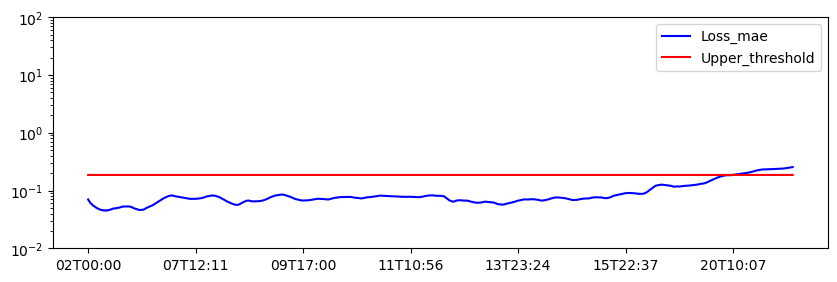

In [43]:
health_rate = []
supply_anomaly = []

df = Create_dataset(tempS_value[5], tempS_time[5], 4800)

supply_scaler = preprocessing.MinMaxScaler()

X = pd.DataFrame(supply_scaler.fit_transform(df), 
                            columns=df.columns,
                            index=df.index)
# Build AutoEncoding model
supply_model = tf.keras.Sequential()
supply_model = AutoEncoder_build(model=supply_model,X_train=X, act_func='relu')
history = AutoEncoder_main(supply_model, X, 100, 128, 0.2)   

plt.figure(figsize=(5, 3))
plt.title("Training loss plot")
plot_AE_history(history)

# For training set
X_pred = supply_model.predict(np.array(X))
X_pred = pd.DataFrame(X_pred,
                    columns=X.columns)
X_pred.index = X.index

scored = pd.DataFrame(index=X.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X), axis = 1)

plt.figure(figsize=(5, 3))
hist = plt.hist(scored['Loss_mae'], bins=50, edgecolor='white', density=True, color='blue')
# plt.title("MAE density plot for training set" + str(i))
sns.kdeplot(scored['Loss_mae'], color='red')

#For testing set
X_pred = supply_model.predict(np.array(X))
X_pred = pd.DataFrame(X_pred, columns=X.columns)
X_pred.index = X.index

scored = pd.DataFrame(index=X.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X), axis = 1)
miu = np.mean(scored['Loss_mae'])
sigma = np.std(scored['Loss_mae'])
scored['Upper_threshold'] = miu + 2 * sigma
# scored['Lower_threshold'] = miu - 35 * sigma
scored['Anomaly'] = scored['Loss_mae'] > scored['Upper_threshold'] 

# X_pred_train = supply_model.predict(np.array(X_train))
# X_pred_train = pd.DataFrame(X_pred_train,
#                       columns=X_train.columns)
# X_pred_train.index = X_train.index

# scored_train = pd.DataFrame(index=X_train.index)
# scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
# scored_train['Threshold'] = supply_threshold
# scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
# scored = pd.concat([scored_train, scored])

scored.plot(logy=True,  figsize = (10,3), ylim = [1e-2,1e2], color = ['blue','red'])

df_anomalies = df.loc[scored[scored['Anomaly']].index]

cnt = 0
for j in scored['Anomaly']:
    if j == False:
        cnt += 1
health_rate.append(cnt/len(scored['Anomaly']))
supply_anomaly.append(df_anomalies)
print(cnt/len(scored['Anomaly']))



In [44]:

miu = np.mean(scored['Loss_mae'])
sigma = np.std(scored['Loss_mae'])
print(miu, sigma)
scored['Upper_threshold'] = miu + 2 * sigma
scored['Lower_threshold'] = miu - 2 * sigma
scored['Anomaly'] = (scored['Loss_mae'] > scored['Upper_threshold']) | (scored['Loss_mae'] < scored['Lower_threshold'])

cnt = 0
for j in scored['Anomaly']:
    if j == False:
        cnt += 1
print(cnt/len(scored['Anomaly']))
print(health_rate)
print(supply_anomaly)


0.09144568537837915 0.04735144757687357
0.9150649826102873
[0.9150649826102873]
[               0          1          2          3          4          5     \
20T10:04  73.699997  75.080002  75.080002  74.900002  75.040001  75.040001   
20T10:05  75.080002  75.080002  74.900002  75.040001  75.040001  75.040001   
20T10:06  75.080002  74.900002  75.040001  75.040001  75.040001  75.540001   
20T10:07  74.900002  75.040001  75.040001  75.040001  75.540001  75.540001   
20T10:08  75.040001  75.040001  75.040001  75.540001  75.540001  75.608002   
...             ...        ...        ...        ...        ...        ...   
21T09:13  75.419998  75.419998  76.015999  75.500000  75.500000  74.720001   
21T09:14  75.419998  76.015999  75.500000  75.500000  74.720001  75.935997   
21T09:15  76.015999  75.500000  75.500000  74.720001  75.935997  75.935997   
21T09:16  75.500000  75.500000  74.720001  75.935997  75.935997  75.952003   
21T09:17  75.500000  74.720001  75.935997  75.935997  75.9520

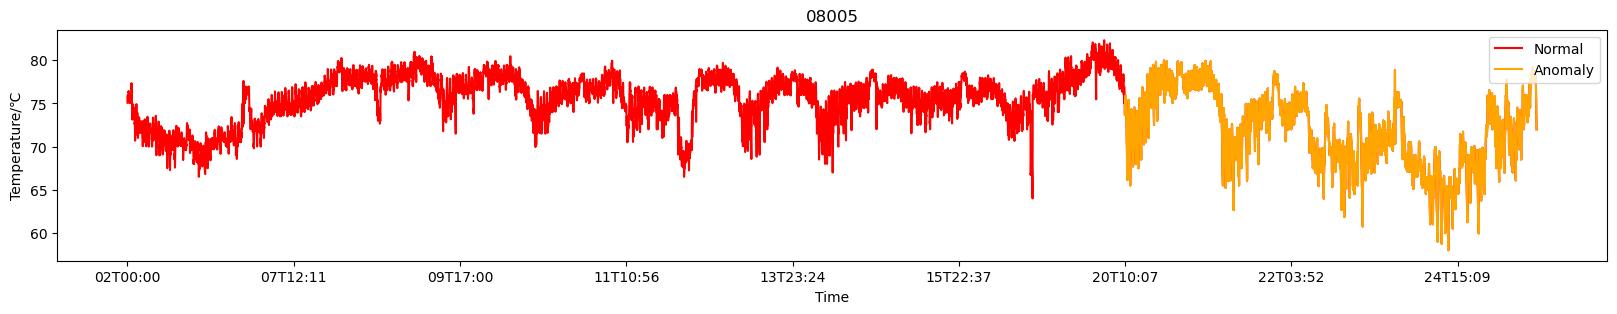

In [46]:
df_pred = pd.DataFrame(supply_scaler.inverse_transform(X_pred), index=X_pred.index, columns=X_pred.columns)

df_anomalies_pred = df_pred.loc[scored[scored['Anomaly']].index] # for significant anomaly

j = 5   #The building index

idx = []
for i in supply_anomaly[0].index:
    if i in tempS_time[j]:
        idx.append(range(tempS_time[j].index(i), tempS_time[j].index(i) + 4800))
idx = np.unique(idx)

plt.figure(figsize=(20, 3))
plt.title(name[j])
plt.xlabel("Time")
plt.ylabel("Temperature/℃")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2500))
plt.plot(tempS_time[j], tempS_value[j], color = 'red', label = 'Normal')
if len(idx):
    start = [idx[0]]
    end = []
    for k in range(1, len(idx)):
        if idx[k] != idx[k-1] + 1:
            start.append(idx[k])
            end.append(idx[k-1])
    end.append(idx[-1])
    flag = True
    for x, y in zip(start, end):
        plt.plot(np.array(tempS_time[j])[x: y], np.array(tempS_value[j])[x: y], color = 'orange', label = 'Anomaly' if flag else None)
        flag = False
plt.legend(loc = 'upper right')



[[0.12752932]
 [0.21493725]
 [0.0706603 ]]


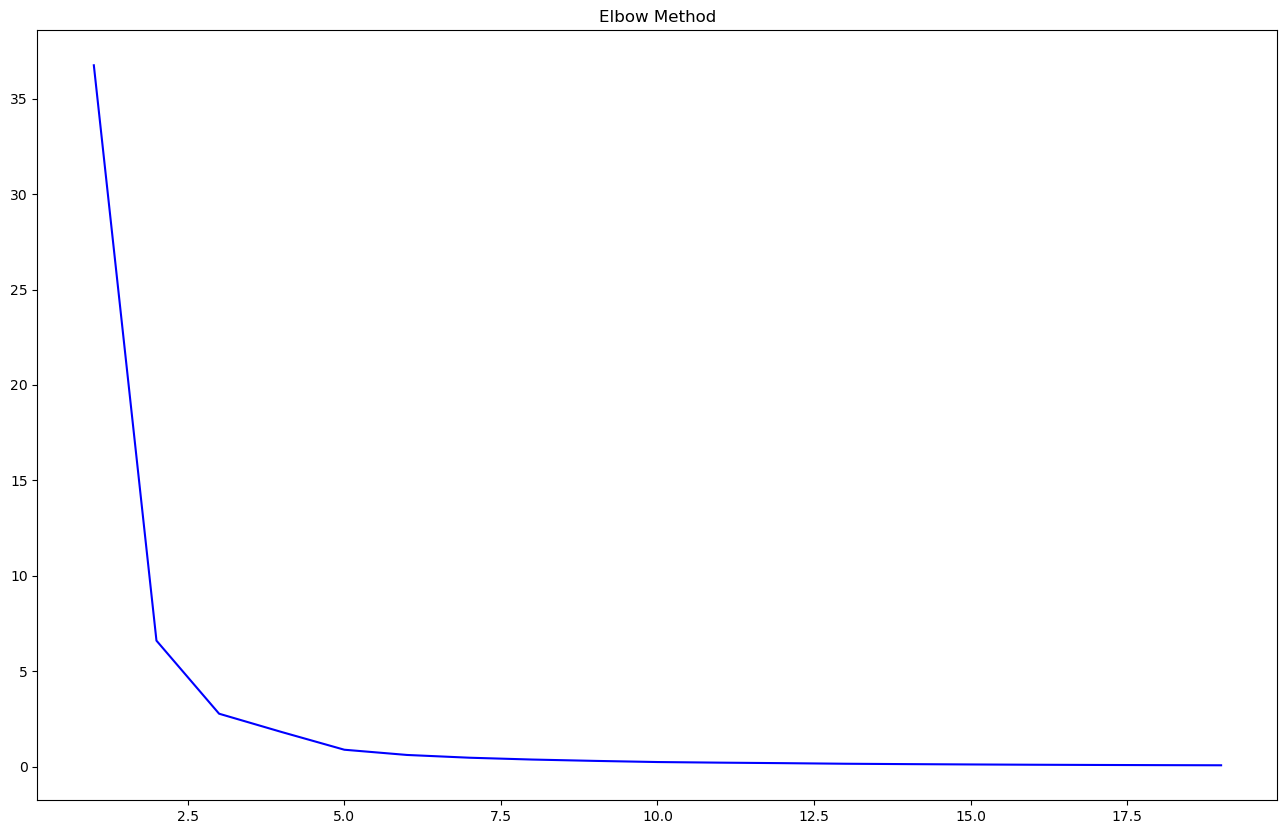

The size of SOM: 26 * 26


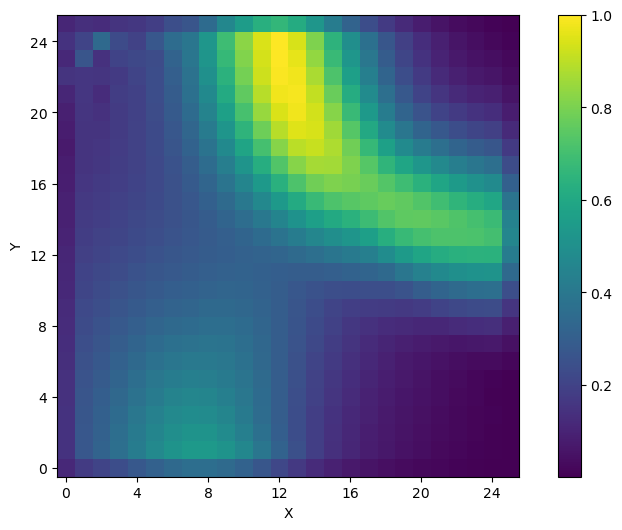

In [48]:
from minisom import MiniSom
from matplotlib.gridspec import GridSpec
import math
from sklearn.cluster import KMeans
import warnings
import copy

warnings.filterwarnings("ignore")

df = Create_dataset(tempS_value[5], tempS_time[5], 4800)  #The building index
X = pd.DataFrame(scored['Loss_mae'], index=scored.index)

std = []
mean = []
for i in np.array(df):
    mean.append(np.mean(i))
    std.append(np.std(i))

km = KMeans(n_clusters=3).fit(X)
centroid = km.cluster_centers_
print(centroid)
repre = []
for i in centroid.flatten():
    idx = np.abs(np.array(scored['Loss_mae']) - i).argmin()
    repre.append(idx)
    
elbow = []
for i in range(1, 20):  
   kmeans = KMeans(n_clusters=i)
   kmeans.fit(X)
   elbow.append(kmeans.inertia_)

k_num = [i for i in range(1, 20)]
plt.plot(k_num, elbow, color='blue')
plt.rcParams.update({'figure.figsize': (16, 10), 'figure.dpi': 100})
plt.title('Elbow Method')
plt.show()

N = X.shape[0]   # length
M = X.shape[1]  # dimension
size = math.ceil(np.sqrt(5 * np.sqrt(N)))
print("The size of SOM: {} * {}".format(size, size))
max_iter = 200
X = np.array(X)
som = MiniSom(size, size, M, sigma=size/2, learning_rate=0.5, neighborhood_function='gaussian')  # sigma determines the range of updating neurons
# som.pca_weights_init(X)
som.train_batch(X, max_iter)

plt.figure(figsize=(10, 6))
heatmap = som.distance_map()  
plt.xlabel("X")
plt.ylabel("Y") 
# plt.title("SOM clustering visualization")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(4))
plt.imshow(heatmap)  
plt.gca().invert_yaxis()
plt.colorbar()






[14194, 15480, 1718]


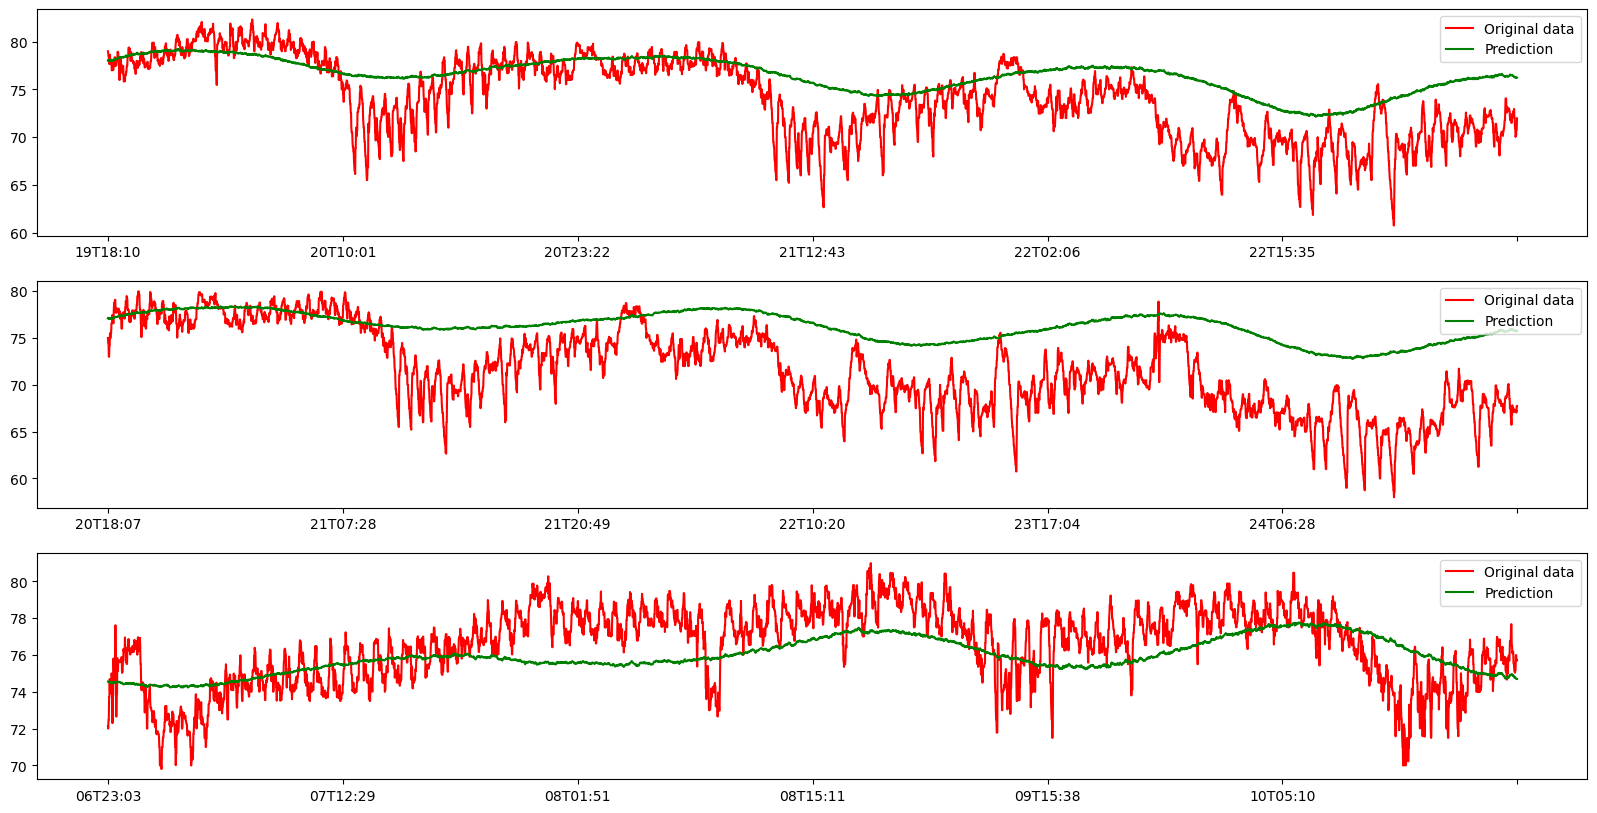

In [51]:
print(repre)
plt.figure(figsize=(20, 10))
for i in range(len(repre)):
    plt.subplot(len(repre), 1, i+1)
    idx = repre[i]
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(800))
    plt.plot(tempS_time[5][idx: idx+4800], tempS_value[5][idx: idx+4800], color='red', label='Original data')  # building index!
    temp = df_pred[tempS_time[5][idx]: tempS_time[5][idx]]
    temp = np.array(temp).flatten()
    plt.plot(tempS_time[5][idx: idx+4800], temp[0: 4800], color='green', label='Prediction')
    plt.legend(loc='upper right')

    

#### Auto-encoder for Return temperature
* Training set: 02

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 180)            │       864,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 16)             │         2,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 180)            │         3,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 4800)           │       868,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,936 (6.63 MB)

 Trainable params: 1,738,936 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 1.0993 - val_loss: 0.0528
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0405 - val_loss: 0.0504
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0412 - val_loss: 0.0496
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0403 - val_loss: 0.0497
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0401 - val_loss: 0.0490
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0393 - val_loss: 0.0500
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0385 - val_loss: 0.0500
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0387 - val_loss: 0.0510
Epoch 9/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0389 - val_loss: 0.0520
Epoch 10/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0391 - val_loss: 0.0502
Epoch 11/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0387 - val_loss: 0.0485
Epoch 12/100
103/103 ━━━

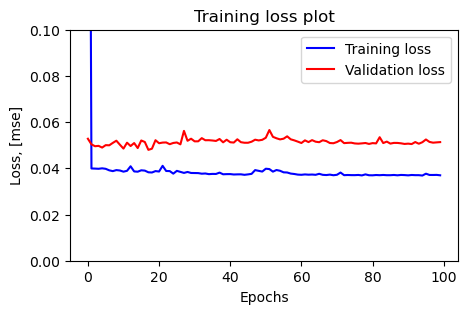

513/513 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
0.9178107267069375


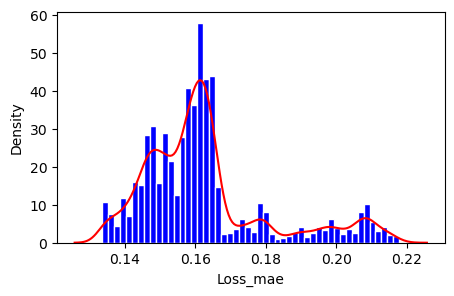

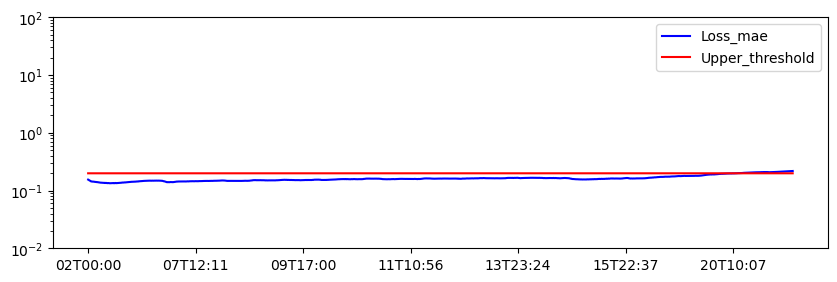

In [81]:
health_rate = []
return_anomaly = []

df = Create_dataset(tempR_value[5], tempR_time[5], 4800)

return_scaler = preprocessing.MinMaxScaler()

X = pd.DataFrame(return_scaler.fit_transform(df), 
                            columns=df.columns,
                            index=df.index)
# Build AutoEncoding model
return_model = tf.keras.Sequential()
return_model = AutoEncoder_build(model=return_model,X_train=X, act_func='relu')
history = AutoEncoder_main(return_model, X, 100, 128, 0.2)   

plt.figure(figsize=(5, 3))
plt.title("Training loss plot")
plot_AE_history(history)

# For training set
X_pred = return_model.predict(np.array(X))
X_pred = pd.DataFrame(X_pred,
                    columns=X.columns)
X_pred.index = X.index

scored = pd.DataFrame(index=X.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X), axis = 1)

plt.figure(figsize=(5, 3))
hist = plt.hist(scored['Loss_mae'], bins=50, edgecolor='white', density=True, color='blue')
# plt.title("MAE density plot for training set" + str(i))
sns.kdeplot(scored['Loss_mae'], color='red')

#For testing set
X_pred = return_model.predict(np.array(X))
X_pred = pd.DataFrame(X_pred, columns=X.columns)
X_pred.index = X.index

scored = pd.DataFrame(index=X.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X), axis = 1)
miu = np.mean(scored['Loss_mae'])
sigma = np.std(scored['Loss_mae'])
scored['Upper_threshold'] = miu + 2 * sigma
# scored['Lower_threshold'] = miu - 35 * sigma
scored['Anomaly'] = scored['Loss_mae'] > scored['Upper_threshold'] 

# X_pred_train = return_model.predict(np.array(X_train))
# X_pred_train = pd.DataFrame(X_pred_train,
#                       columns=X_train.columns)
# X_pred_train.index = X_train.index

# scored_train = pd.DataFrame(index=X_train.index)
# scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
# scored_train['Threshold'] = return_threshold
# scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
# scored = pd.concat([scored_train, scored])

scored.plot(logy=True,  figsize = (10,3), ylim = [1e-2,1e2], color = ['blue','red'])

df_anomalies = df.loc[scored[scored['Anomaly']].index]

cnt = 0
for j in scored['Anomaly']:
    if j == False:
        cnt += 1
health_rate.append(cnt/len(scored['Anomaly']))
return_anomaly.append(df_anomalies)
print(cnt/len(scored['Anomaly']))



In [82]:

miu = np.mean(scored['Loss_mae'])
sigma = np.std(scored['Loss_mae'])
print(miu, sigma)
scored['Upper_threshold'] = miu + 2 * sigma
scored['Lower_threshold'] = miu - 2 * sigma
scored['Anomaly'] = (scored['Loss_mae'] > scored['Upper_threshold']) | (scored['Loss_mae'] < scored['Lower_threshold'])

cnt = 0
for j in scored['Anomaly']:
    if j == False:
        cnt += 1
print(cnt/len(scored['Anomaly']))
print(health_rate)
print(return_anomaly)


0.1623265287571161 0.01821780996540104
0.9178107267069375
[0.9178107267069375]
[               0          1          2          3          4          5     \
20T10:41  50.799999  50.799999  39.849998  47.200001  47.200001  59.599998   
20T10:42  50.799999  39.849998  47.200001  47.200001  59.599998  59.599998   
20T10:43  39.849998  47.200001  47.200001  59.599998  59.599998  57.150002   
20T10:44  47.200001  47.200001  59.599998  59.599998  57.150002  33.500000   
20T10:45  47.200001  59.599998  59.599998  57.150002  33.500000  33.500000   
...             ...        ...        ...        ...        ...        ...   
21T09:13  48.900002  48.900002  54.349998  55.400002  55.400002  30.575001   
21T09:14  48.900002  54.349998  55.400002  55.400002  30.575001  57.849998   
21T09:15  54.349998  55.400002  55.400002  30.575001  57.849998  57.849998   
21T09:16  55.400002  55.400002  30.575001  57.849998  57.849998  31.924999   
21T09:17  55.400002  30.575001  57.849998  57.849998  31.92499

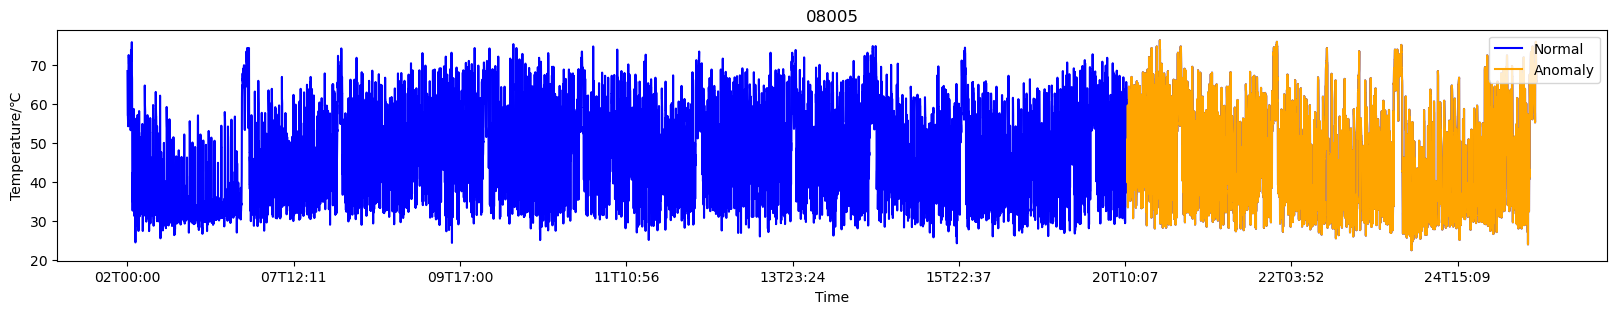

In [87]:
df_pred = pd.DataFrame(return_scaler.inverse_transform(X_pred), index=X_pred.index, columns=X_pred.columns)

df_anomalies_pred = df_pred.loc[scored[scored['Anomaly']].index] # for significant anomaly

j = 5   #The building index

idx = []
for i in return_anomaly[0].index:
    if i in tempR_time[j]:
        idx.append(range(tempR_time[j].index(i), tempR_time[j].index(i) + 4800))
idx = np.unique(idx)

plt.figure(figsize=(20, 3))
plt.title(name[j])
plt.xlabel("Time")
plt.ylabel("Temperature/℃")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2500))
plt.plot(tempR_time[j], tempR_value[j], color = 'blue', label = 'Normal')
if len(idx):
    start = [idx[0]]
    end = []
    for k in range(1, len(idx)):
        if idx[k] != idx[k-1] + 1:
            start.append(idx[k])
            end.append(idx[k-1])
    end.append(idx[-1])
    flag = True
    for x, y in zip(start, end):
        plt.plot(np.array(tempR_time[j])[x: y], np.array(tempR_value[j])[x: y], color = 'orange', label = 'Anomaly' if flag else None)
        flag = False
plt.legend(loc = 'upper right')



[[0.14645769]
 [0.16315716]
 [0.20238148]]
The size of SOM: 26 * 26


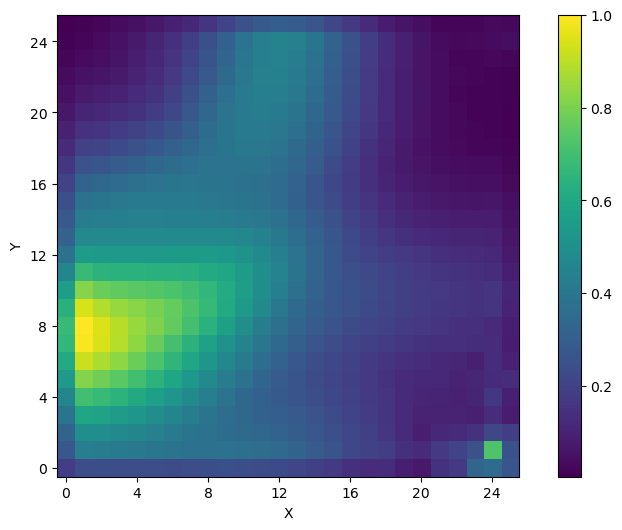

In [89]:
from minisom import MiniSom
from matplotlib.gridspec import GridSpec
import math
from sklearn.cluster import KMeans
import warnings
import copy

warnings.filterwarnings("ignore")

df = Create_dataset(tempR_value[5], tempR_time[5], 4800)  #The building index
X = pd.DataFrame(scored['Loss_mae'], index=scored.index)

std = []
mean = []
for i in np.array(df):
    mean.append(np.mean(i))
    std.append(np.std(i))

km = KMeans(n_clusters=3).fit(X)
centroid = km.cluster_centers_
print(centroid)
repre = []
for i in centroid.flatten():
    idx = np.abs(np.array(scored['Loss_mae']) - i).argmin()
    repre.append(idx)
    
# elbow = []
# for i in range(1, 20):  
#    kmeans = KMeans(n_clusters=i)
#    kmeans.fit(X)
#    elbow.append(kmeans.inertia_)

# k_num = [i for i in range(1, 20)]
# plt.plot(k_num, elbow, color='blue')
# plt.rcParams.update({'figure.figsize': (16, 10), 'figure.dpi': 100})
# plt.title('Elbow Method')
# plt.show()

N = X.shape[0]   # length
M = X.shape[1]  # dimension
size = math.ceil(np.sqrt(5 * np.sqrt(N)))
print("The size of SOM: {} * {}".format(size, size))
max_iter = 200
X = np.array(X)
som = MiniSom(size, size, M, sigma=size/2, learning_rate=0.5, neighborhood_function='gaussian')  # sigma determines the range of updating neurons
# som.pca_weights_init(X)
som.train_batch(X, max_iter)

plt.figure(figsize=(10, 6))
heatmap = som.distance_map()  
plt.xlabel("X")
plt.ylabel("Y") 
# plt.title("SOM clustering visualization")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(4))
plt.imshow(heatmap)  
plt.gca().invert_yaxis()
plt.colorbar()






[2796, 12576, 15251]


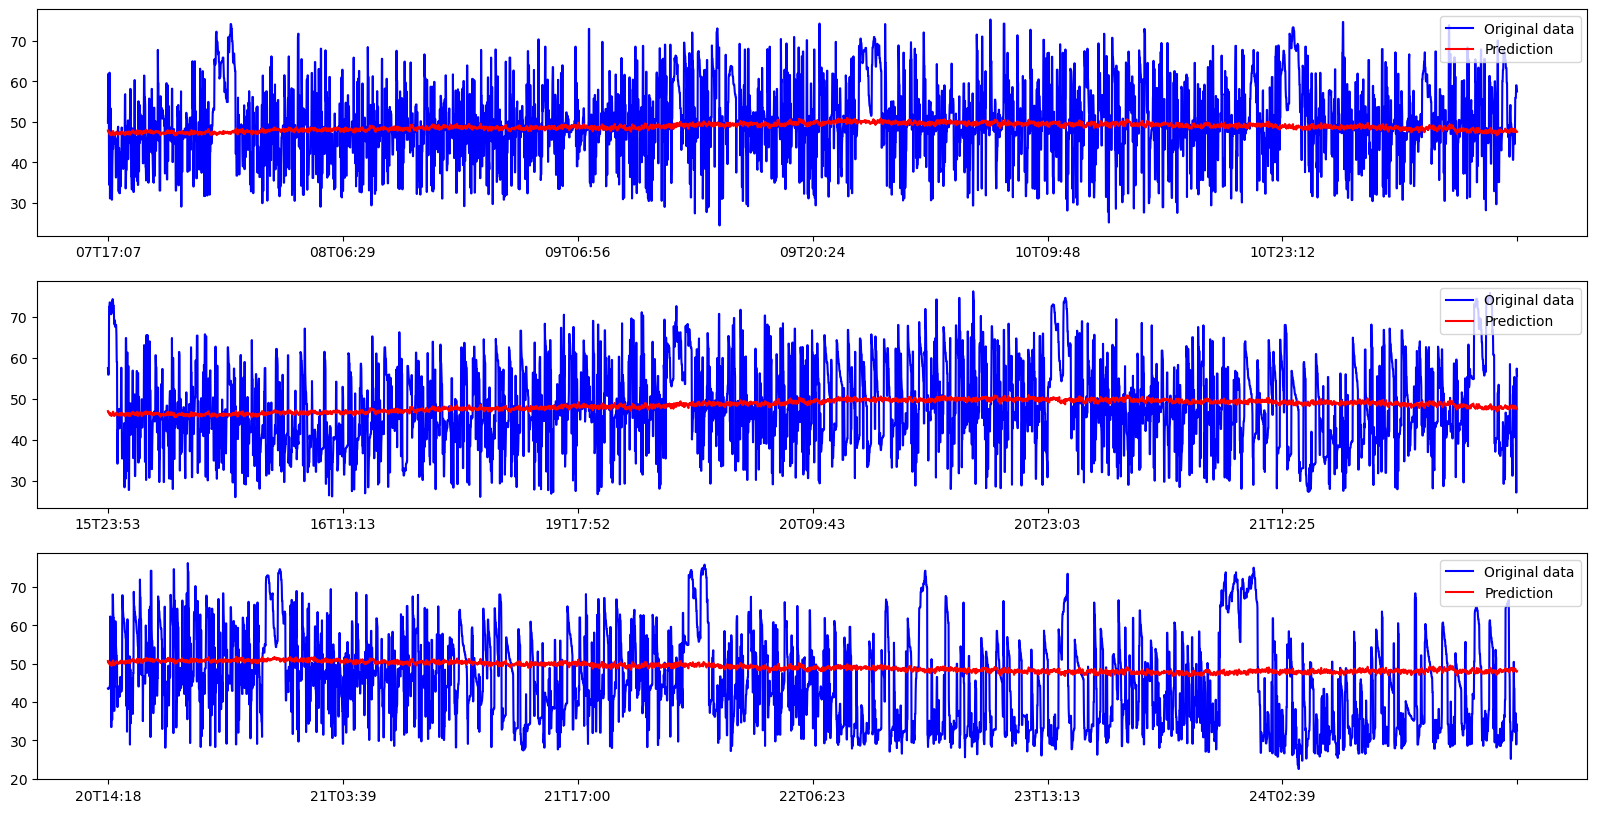

In [90]:
print(repre)
plt.figure(figsize=(20, 10))
for i in range(len(repre)):
    plt.subplot(len(repre), 1, i+1)
    idx = repre[i]
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(800))
    plt.plot(tempR_time[5][idx: idx+4800], tempR_value[5][idx: idx+4800], color='blue', label='Original data')  # building index!
    temp = df_pred[tempR_time[5][idx]: tempR_time[5][idx]]
    temp = np.array(temp).flatten()
    plt.plot(tempR_time[5][idx: idx+4800], temp[0: 4800], color='red', label='Prediction')
    plt.legend(loc='upper right')

    